[rioxarray](https://corteva.github.io/rioxarray/) is an extension of the powerful Python library Xarray that focuses on geospatial raster data. It provides easy access to georeferencing information and geospatial transforms using Xarray’s labeled, multi-dimensional data structures, which makes it an ideal tool for working with geospatial data like satellite imagery or climate data.

The key feature of `rioxarray` is its seamless integration of rasterio’s geospatial data handling capabilities (such as CRS and affine transforms) with Xarray’s efficient multi-dimensional array handling. This allows you to manipulate, analyze, and visualize raster data with ease.

# Learning Objectives
By the end of this lecture, you should be able to:

- Understand how `rioxarray` extends Xarray for geospatial data handling.
- Load and inspect georeferenced raster datasets using `rioxarray`.
- Perform basic geospatial operations, such as clipping, reprojection, and masking, using `rioxarray`.
- Use `rioxarray` to manage CRS and spatial dimensions in raster datasets.
- Export and visualize geospatial raster datasets.

# Importing rioxarray

In [1]:
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

xr.set_options(keep_attrs=True, display_expand_data=False)

# Loading Georeferenced Raster Data
One of the core functionalities of `rioxarray` is the ability to load georeferenced raster data, including its CRS and geospatial transformations. You can load a raster file (e.g., a GeoTIFF file) directly using `rioxarray`:

In [2]:
# Load a raster dataset using rioxarray
url = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"
data = rioxarray.open_rasterio(url)
data

<xarray.DataArray (band: 7, y: 2563, x: 2485)> Size: 178MB
[44583385 values with dtype=float32]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 20kB 5.824e+05 5.825e+05 ... 8.059e+05 8.06e+05
  * y            (y) float64 21kB 4.106e+06 4.105e+06 ... 3.875e+06 3.875e+06
    spatial_ref  int64 8B 0
Attributes: (12/96)
    ALGORITHM_SOURCE_SURFACE_REFLECTANCE:  LaSRC_1.6.0
    ALGORITHM_SOURCE_SURFACE_TEMPERATURE:  st_1.5.0
    CLOUD_COVER:                           0
    CLOUD_COVER_LAND:                      0
    COLLECTION_CATEGORY:                   T1
    COLLECTION_NUMBER:                     2
    ...                                    ...
    WRS_TYPE:                              2
    AREA_OR_POINT:                         Area
    _FillValue:                            -inf
    scale_factor:                          1.0
    add_offset:                            0.0
    long_name:                             ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4...

Here, `rioxarray.open_rasterio` loads the raster data into an Xarray DataArray and automatically attaches the geospatial metadata, including CRS, affine transformations, and spatial coordinates.

# Inspecting the Dataset
You can easily inspect the loaded dataset, including its dimensions, coordinates, and attributes:

In [3]:
# View the structure of the DataArray
data.dims  # Dimensions (e.g., band, y, x)

('band', 'y', 'x')

In [4]:
data.coords  # Coordinates (e.g., y, x in geographic or projected CRS)

Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 20kB 5.824e+05 5.825e+05 ... 8.059e+05 8.06e+05
  * y            (y) float64 21kB 4.106e+06 4.105e+06 ... 3.875e+06 3.875e+06
    spatial_ref  int64 8B 0

In [5]:
print(data.attrs)  # Metadata (including CRS)

{'ALGORITHM_SOURCE_SURFACE_REFLECTANCE': 'LaSRC_1.6.0', 'ALGORITHM_SOURCE_SURFACE_TEMPERATURE': 'st_1.5.0', 'CLOUD_COVER': 0, 'CLOUD_COVER_LAND': 0, 'COLLECTION_CATEGORY': 'T1', 'COLLECTION_NUMBER': 2, 'DATA_SOURCE_AIR_TEMPERATURE': 'VIIRS', 'DATA_SOURCE_ELEVATION': 'GLS2000', 'DATA_SOURCE_OZONE': 'VIIRS', 'DATA_SOURCE_PRESSURE': 'Calculated', 'DATA_SOURCE_REANALYSIS': 'GEOS-5 IT', 'DATA_SOURCE_WATER_VAPOR': 'VIIRS', 'DATE_ACQUIRED': '2024-07-08', 'DATE_PRODUCT_GENERATED': 1720562288000, 'DATUM': 'WGS84', 'EARTH_SUN_DISTANCE': 1.016687, 'ELLIPSOID': 'WGS84', 'GEOMETRIC_RMSE_MODEL': 3.828, 'GEOMETRIC_RMSE_MODEL_X': 2.822, 'GEOMETRIC_RMSE_MODEL_Y': 2.586, 'GEOMETRIC_RMSE_VERIFY': 1.342, 'GRID_CELL_SIZE_REFLECTIVE': 30, 'GRID_CELL_SIZE_THERMAL': 30, 'GROUND_CONTROL_POINTS_MODEL': 1015, 'GROUND_CONTROL_POINTS_VERIFY': 244, 'GROUND_CONTROL_POINTS_VERSION': 5, 'IMAGE_QUALITY_OLI': 9, 'IMAGE_QUALITY_TIRS': 9, 'L1_DATE_PRODUCT_GENERATED': '2024-07-08T23:15:25Z', 'L1_LANDSAT_PRODUCT_ID': 'LC09_

# Checking CRS and Transform Information
`rioxarray` integrates CRS and affine transform metadata into the Xarray object:

In [6]:
# Check the CRS of the dataset
data.rio.crs

CRS.from_epsg(32611)

In [7]:
# Check the affine transformation (mapping pixel coordinates to geographic coordinates)
data.rio.transform()

Affine(90.0, 0.0, 582390.0,
       0.0, -90.0, 4105620.0)

Sometimes, raster data may not have a CRS, or the CRS could be incorrect. You can assign a CRS manually if necessary

In [8]:
# If the CRS is missing or incorrect, assign a CRS
data = data.rio.write_crs("EPSG:32611", inplace=True)

In [9]:
data.rio.crs

CRS.from_epsg(32611)

# Basic Geospatial Operations

## Reprojecting a Dataset

Reprojecting raster data to another CRS is common in geospatial analysis. For example, you may want to reproject the dataset from its native projection to the WGS84 geographic coordinate system (EPSG:4326):

In [10]:
# Reproject the dataset to WGS84 (EPSG:4326)
data_reprojected = data.rio.reproject("EPSG:4326")
print(data_reprojected.rio.crs)

EPSG:4326


## Clipping a Raster
Clipping a raster dataset is useful when you only want to focus on a specific geographic area. You can clip a dataset using a bounding box in the same CRS as the data:

In [11]:
# Define a bounding box (in the same CRS as the dataset)
bbox = [-115.391, 35.982, -114.988, 36.425]

# Clip the raster to the bounding box
clipped_data = data_reprojected.rio.clip_box(*bbox)

In [12]:
clipped_data.shape

(7, 492, 447)

Alternatively, you can clip the raster using a vector dataset containing polygon geometries:

In [13]:
import geopandas as gpd

# Load a geojson with regions of interest
geojson_path = "https://github.com/opengeos/datasets/releases/download/places/las_vegas_bounds_utm.geojson"
bounds = gpd.read_file(geojson_path)

# Clip the raster to the shape
clipped_data2 = data.rio.clip(bounds.geometry, bounds.crs)

In [14]:
clipped_data2.shape

(7, 522, 514)

# Working with Spatial Dimensions
`rioxarray` supports operations on spatial dimensions (latitude/longitude or x/y coordinates) like resampling, reducing, or slicing.

## Resampling
To resample the raster dataset to a different resolution (e.g., 1 km), use the `rio.resample` method:

In [15]:
# Resample to 1km resolution (using an average resampling method)
resampled_data = data.rio.reproject(data.rio.crs, resolution=(1000, 1000))

In [16]:
resampled_data.shape

(7, 231, 224)

## Extracting Spatial Subsets
You can extract spatial subsets of the dataset by selecting specific coordinate ranges:

In [17]:
# Select a subset of the data within a lat/lon range
min_x, max_x = -115.391, -114.988
min_y, max_y = 35.982, 36.425
subset = data_reprojected.sel(
    x=slice(min_x, max_x), y=slice(max_y, min_y)
)  # Slice y in reverse order
subset.shape

(7, 491, 447)

# Visualization of Georeferenced Data
Once you have performed operations on the data, you can visualize it using matplotlib. For example, to plot a multi-band image using bands 4, 3, and 2:

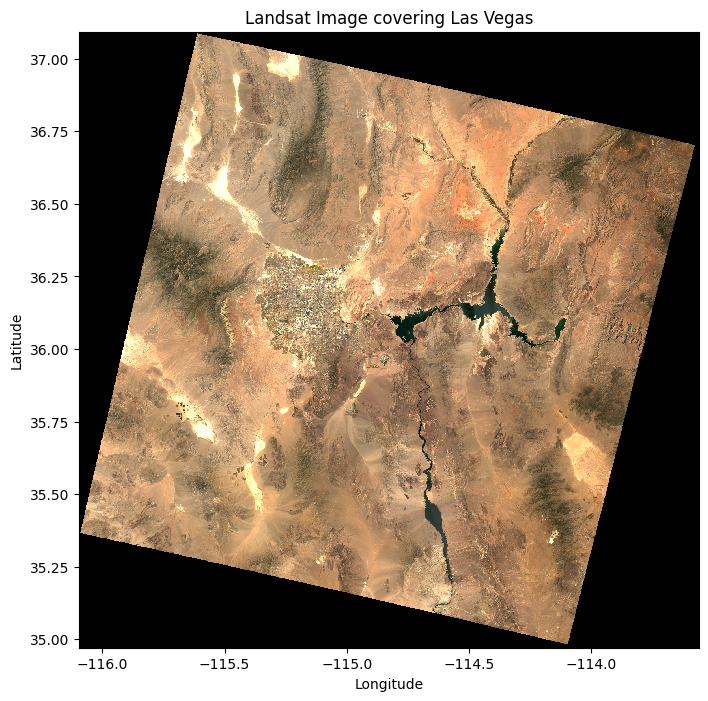

In [18]:
# Plot the raster data
plt.figure(figsize=(8, 8))
data_reprojected.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3)
plt.title("Landsat Image covering Las Vegas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

You can also visualize clipped or masked data in the same way:

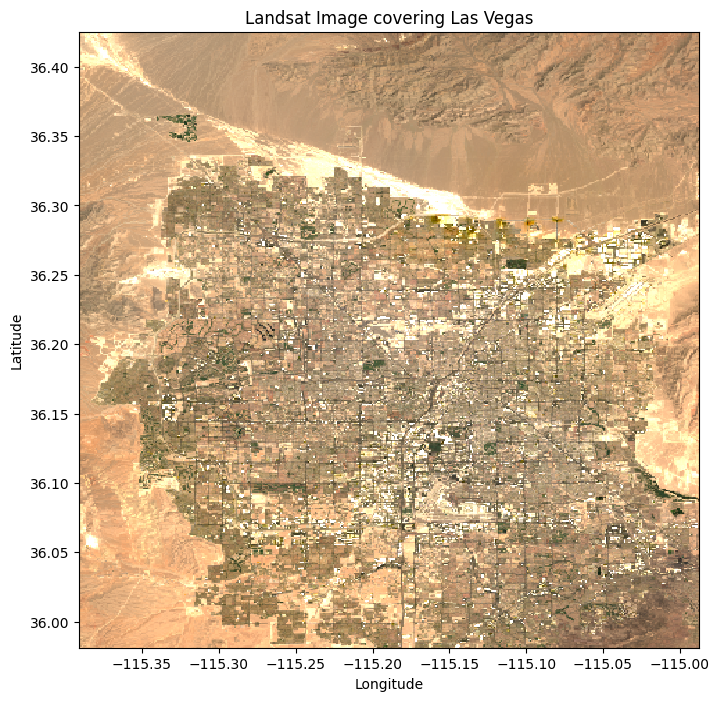

In [19]:
# Plot the raster data
plt.figure(figsize=(8, 8))
clipped_data.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3)
plt.title("Landsat Image covering Las Vegas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

For more advanced plots, such as overlaying a vector dataset on the raster data, you can combine `rioxarray` with `geopandas` and `matplotlib`:

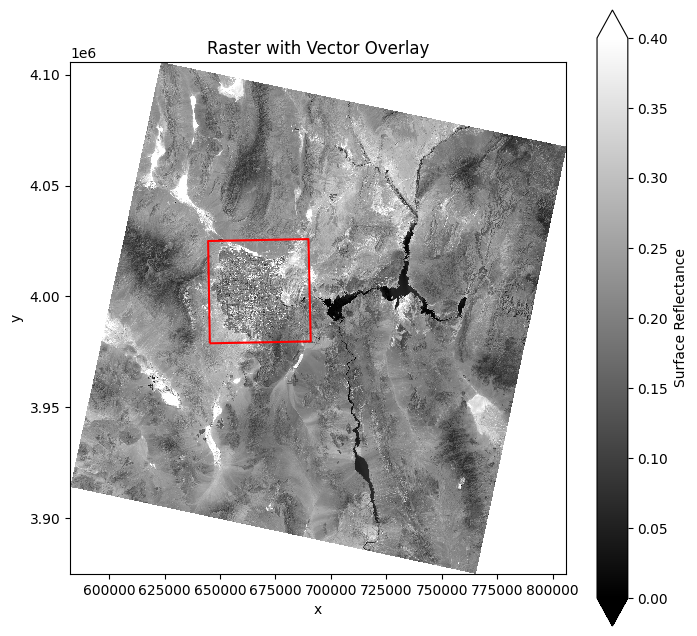

In [20]:
# Plot raster with GeoJSON overlay
fig, ax = plt.subplots(figsize=(8, 8))
data.attrs["long_name"] = "Surface Reflectance"  # Update the long_name attribute
data.sel(band=4).plot.imshow(ax=ax, vmin=0, vmax=0.4, cmap="gray")
bounds.boundary.plot(ax=ax, color="red")
plt.title("Raster with Vector Overlay")
plt.show()

# Saving Data
Just like loading data, you can export `rioxarray` datasets to disk. For example, you can save the modified or processed raster data as a GeoTIFF file:

In [21]:
# Save the DataArray as a GeoTIFF file
data.rio.to_raster("./_out/output_raster.tif")

# Handling NoData Values
If your dataset contains NoData values, you can manage them using the following functions:

In [22]:
# Assign NoData value
data2 = data.rio.set_nodata(-9999)

# Remove NoData values (mask them)
data_clean = data2.rio.write_nodata(-9999, inplace=True)

# Reproject to Multiple CRS
You can reproject the dataset to multiple CRS and compare them. For instance:

In [23]:
# Reproject to WGS 84 (EPSG:4326)
data = data.rio.reproject("EPSG:4326")
print(data.rio.crs)

EPSG:4326


In [24]:
# Reproject to EPSG:3857 (Web Mercator)
mercator_data = data.rio.reproject("EPSG:3857")
print(mercator_data.rio.crs)

EPSG:3857


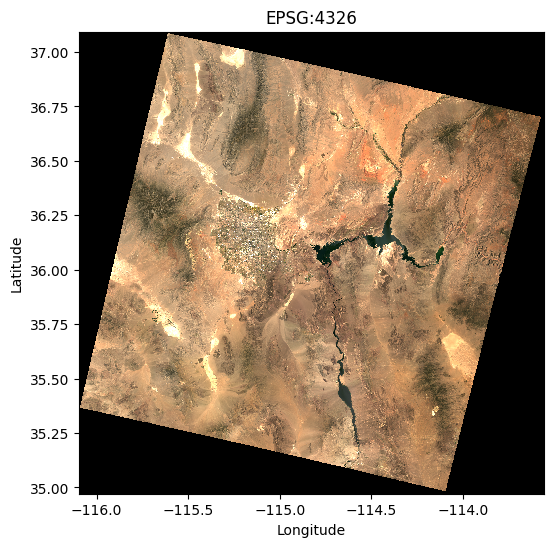

In [25]:
# Plot the raster data in WGS84
plt.figure(figsize=(6, 6))
data.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3)
plt.title("EPSG:4326")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

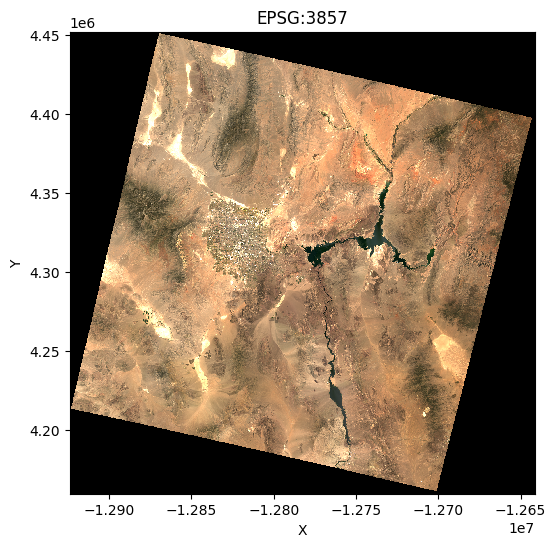

In [26]:
# Plot the raster data in Web Mercator
plt.figure(figsize=(6, 6))
mercator_data.sel(band=[4, 3, 2]).plot.imshow(vmin=0, vmax=0.3)
plt.title("EPSG:3857")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Basic Band Math (NDVI Calculation)
Band math enables us to perform computations across different bands. A common application is calculating the Normalized Difference Vegetation Index (NDVI), which is an indicator of vegetation health.

NDVI is calculated as:

NDVI = (NIR - Red) / (NIR + Red)

We can compute and plot the NDVI as follows:

In [27]:
# Select the red (band 4) and NIR (band 5) bands
red_band = data.sel(band=4)
nir_band = data.sel(band=5)

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndvi = ndvi.clip(min=-1, max=1)  # Clip values to the range [-1, 1]
ndvi.attrs["long_name"] = "NDVI"

To visualize the NDVI, we can plot it using matplotlib:

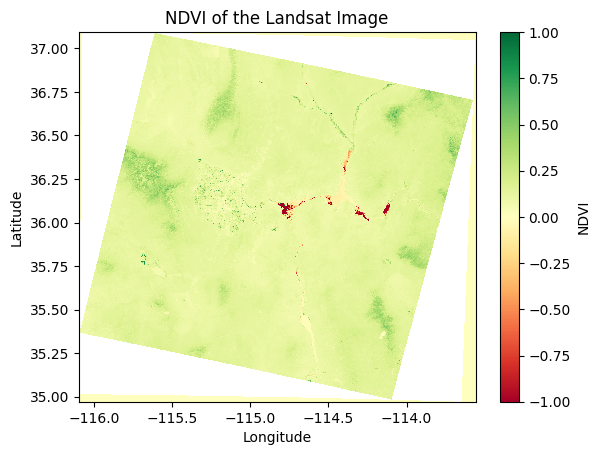

In [28]:
# Plot the NDVI values
ndvi.plot(cmap="RdYlGn", vmin=-1, vmax=1)
plt.title("NDVI of the Landsat Image")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

You can also mask out non-vegetated areas or areas with invalid NDVI values (such as water or urban regions) by applying a threshold:

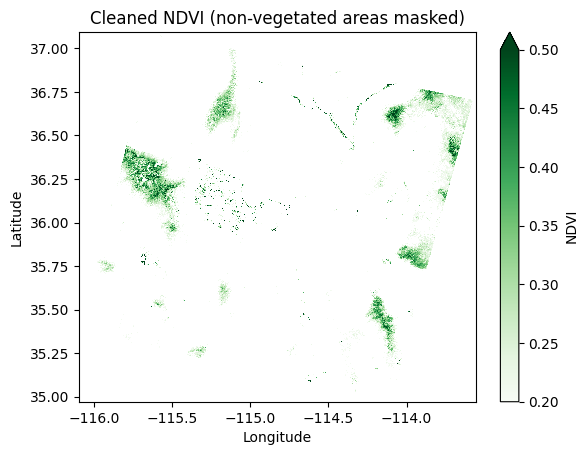

In [29]:
# Mask out non-vegetated areas (NDVI < 0.2)
ndvi_clean = ndvi.where(ndvi > 0.2)
ndvi_clean.plot(cmap="Greens", vmin=0.2, vmax=0.5)
plt.title("Cleaned NDVI (non-vegetated areas masked)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Exercises

## Sample Dataset
For the exercises, we will use a sample GeoTIFF raster dataset of Libya, which is available at the following URL: [opengeos/datasets](https://github.com/opengeos/datasets/releases/download/raster/Libya-2023-09-13.tif)

## Exercise 1: Load and Inspect a Raster Dataset
1. Use `rioxarray` to load the GeoTIFF raster file.
2. Inspect the dataset by printing its dimensions, coordinates, and attributes.
3. Check and print the CRS and affine transformation of the dataset.

## Exercise 2: Reproject the Raster to a New CRS
1. Reproject the loaded raster dataset from its original CRS to EPSG:4326 (WGS84).
2. Print the new CRS and check the dimensions and coordinates of the reprojected data.
3. Plot the original and reprojected datasets for comparison.

## Exercise 3: Clip the Raster Using a Bounding Box
1. Define a bounding box (e.g., `xmin`, `ymin`, `xmax`, `ymax`) that covers the land area of Libya.
2. Clip the raster dataset using this bounding box.
3. Plot the clipped data to visualize the result.

## Exercise 4: Mask the Raster Using a Vector Dataset
1. Load the GeoJSON file at [opengeos/datasets](https://github.com/opengeos/datasets/releases/download/raster/Derna_Libya.geojson) using `geopandas`.
2. Use the GeoJSON to mask the raster dataset, keeping only the data within the GeoJSON boundaries.
3. Plot the masked raster data.

## Exercise 5: Resample the Raster to a Different Resolution
1. Resample the raster dataset to a 3m resolution, using an average resampling method.
2. Check the new dimensions and coordinates after resampling.
3. Save the resampled raster dataset as a new GeoTIFF file.

# Summary
In this lecture, we have explored the basic functionality of `rioxarray`, a powerful extension of Xarray designed for geospatial raster data. Key points include:

- Loading and inspecting geospatial raster data with CRS and transform metadata.
- Performing essential geospatial operations, such as reprojection, clipping, and masking.
- Visualizing and exporting raster data.
- Working with spatial dimensions (x, y) using slicing, resampling, and other operations.

By integrating Xarray’s multi-dimensional data handling capabilities with rasterio’s geospatial features, `rioxarray` makes it easier to manage and analyze geospatial raster datasets. It is a versatile tool for anyone working with geospatial data in scientific computing, environmental analysis, or remote sensing.